# NLP: Yelp Review to Rating
## :)

In [1]:
import json
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

In [2]:
# importing torch
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1) #for reproducibility

In [18]:
yelp = pd.read_json("./yelp_review_training_dataset.jsonl", lines = True)
yelp.head()

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1


### EDA - Stars
Not too much to go off of, but let's get a general understanding of our data. How many nulls do we have?

In [19]:
yelp.isna().sum()

review_id    0
text         0
stars        0
dtype: int64

How large is the data?

In [20]:
yelp.shape

(533581, 3)

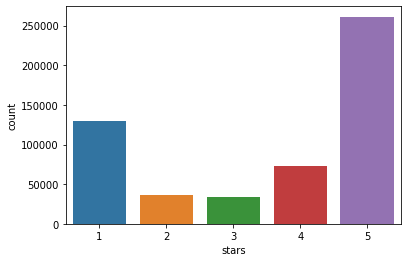

In [21]:
sns.countplot(yelp['stars'])

One thing we can potentially look at is whether or not the reviews are balanced. Let's say >=4 is positive, and <4 is negative. If we do see a significant difference in positive and negative reviews, we can balance it before training.

In [22]:
def pos_or_neg(x):
    if x >= 4:
        return "Positive"
    else:
        return "Negative"
    
yelp['category'] = yelp['stars'].apply(pos_or_neg)
yelp.head()

,review_id,text,stars,category
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1,Negative
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5,Positive
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5,Positive
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5,Positive
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1,Negative


1.6679183395916979

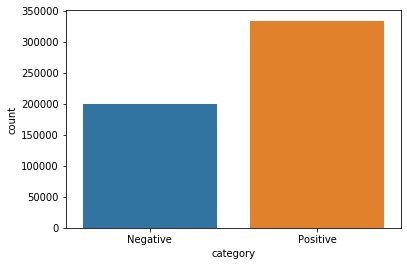

In [27]:
sns.countplot(yelp['category'])
num_pos = np.count_nonzero(yelp['category'] == 'Positive')
num_neg = np.count_nonzero(yelp['category'] == 'Negative')
num_pos / num_neg

There are roughly 1 and 2/3 times as many positive reviews as negative reviews. We will first try no class balancing when building the model, but may turn to class balancing later on.

### Data Cleaning - Text

In [33]:
yelp['text'][17]

'I love chinese food and I love mexican food. What can go wrong? A couple of things. First things first, this place is more of a "rice bowl" kind of place. I thought it was going to be more diverse as far as the menu goes, but its mainly rice bowls you get with different kinds of meats. The ordering was a little confusing at first, but one of the employees helped us out and I got the 2-item bowl and got the jade chicken and hengrenade chicken with all rice(jerk). I also ordered a jade chicken quesadilla on the side.\n\nI\'m gonna admit, this place looks kinda dirty. I don\'t think Arizona uses those health department letter grade system like California does, but if I were to just judge by how it looked inside, i\'d give it a "C" grade lol. We waited for about 15 minutes or so and finally got our food. We took it to go and ate at our hotel room. \n\nMmmm... the food was just alright. The jade chicken was nothing special. It tasted like any generic chinese fast food orange chicken/sesame